In [1]:
from src.sar_transformer.utils import load_concat_transformer
from src.sar_transformer.eval import evaluate_ad_agent
from src.sar_transformer.dataset import HistoryDataset, create_history_dataloader
from src.sar_transformer.eval import evaluate_ad_agent
from src.generation import *

import torch
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import einops
from tqdm import tqdm

import transformer_lens
from transformer_lens import utils
from transformer_lens.head_detector import *

import plotly.express as px

%matplotlib inline

pygame 2.3.0 (SDL 2.24.2, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# model = load_concat_transformer("models\dark_room_test__1000__1685416926_checkpoints\checkpoint_epoch_200.pt").to("cuda")
model = load_concat_transformer("models\dark_room_test__1000__1686153478_checkpoints\checkpoint_epoch_300.pt").to("cuda")
env_config = model.environment_config

In [3]:
model.transformer_config

TransformerModelConfig(d_model=256, n_heads=4, d_mlp=2048, d_head=64, n_layers=6, n_ctx=240, layer_norm=True, attn_only=False, state_embedding_type='linear', time_embedding_type='embedding', seed=1, device=device(type='cuda'))

### Setup Head Detection


In [4]:
def plot_attn_pattern_from_cache(cache: ActivationCache, layer_i: int):
    attention_pattern = cache["pattern", layer_i, "attn"].squeeze(0)
    attention_pattern = einops.rearrange(attention_pattern, "heads seq1 seq2 -> seq1 seq2 heads")
    print(f"Layer {layer_i} Attention Heads:")
    return pysvelte.AttentionMulti(tokens=model.to_str_tokens(prompt), attention=attention_pattern)

In [5]:
# Previous token head
def get_previous_token_head_detection_pattern(
    tokens: torch.Tensor,  # [batch (1) x pos]
) -> torch.Tensor:
    """Outputs a detection score for [previous token heads](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=0O5VOHe9xeZn8Ertywkh7ioc).

    Args:
      tokens: Tokens being fed to the model.
    """
    detection_pattern = torch.zeros(tokens.shape[-1], tokens.shape[-1])
    # Adds a diagonal of 1's below the main diagonal.
    detection_pattern[1:, :-1] = torch.eye(tokens.shape[-1] - 1)
    return torch.tril(detection_pattern)


# Duplicate token head
def get_duplicate_token_head_detection_pattern(
    tokens: torch.Tensor,  # [batch (1) x pos]
) -> torch.Tensor:
    """Outputs a detection score for [duplicate token heads](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=2UkvedzOnghL5UHUgVhROxeo).

    Args:
      sequence: String being fed to the model.
    """
    # [pos x pos]
    token_pattern = tokens.repeat(tokens.shape[-1], 1).numpy()

    # If token_pattern[i][j] matches its transpose, then token j and token i are duplicates.
    eq_mask = np.equal(token_pattern, token_pattern.T).astype(int)

    np.fill_diagonal(
        eq_mask, 0
    )  # Current token is always a duplicate of itself. Ignore that.
    detection_pattern = eq_mask.astype(int)
    return torch.tril(torch.as_tensor(detection_pattern).float())


# Induction head
def get_induction_head_detection_pattern(
    tokens: torch.Tensor,  # [batch (1) x pos]
) -> torch.Tensor:
    """Outputs a detection score for [induction heads](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=_tFVuP5csv5ORIthmqwj0gSY).

    Args:
      sequence: String being fed to the model.
    """
    duplicate_pattern = get_duplicate_token_head_detection_pattern(tokens)

    # Shift all items one to the right
    shifted_tensor = torch.roll(duplicate_pattern, shifts=1, dims=1)

    # Replace first column with 0's
    # we don't care about bos but shifting to the right moves the last column to the first,
    # and the last column might contain non-zero values.
    zeros_column = torch.zeros(duplicate_pattern.shape[0], 1)
    result_tensor = torch.cat((zeros_column, shifted_tensor[:, 1:]), dim=1)
    return torch.tril(result_tensor)


def get_supported_heads() -> None:
    """Returns a list of supported heads."""
    print(f"Supported heads: {HEAD_NAMES}")


def compute_head_attention_similarity_score(
    attention_pattern: torch.Tensor,  # [q_pos k_pos]
    detection_pattern: torch.Tensor,  # [seq_len seq_len] (seq_len == q_pos == k_pos)
    *,
    exclude_bos: bool,
    exclude_current_token: bool,
    error_measure,
) -> float:
    """Compute the similarity between `attention_pattern` and `detection_pattern`.

    Args:
      attention_pattern: Lower triangular matrix (Tensor) representing the attention pattern of a particular attention head.
      detection_pattern: Lower triangular matrix (Tensor) representing the attention pattern we are looking for.
      exclude_bos: `True` if the beginning-of-sentence (BOS) token should be omitted from comparison. `False` otherwise.
      exclude_bcurrent_token: `True` if the current token at each position should be omitted from comparison. `False` otherwise.
      error_measure: "abs" for using absolute values of element-wise differences as the error measure. "mul" for using element-wise multiplication (legacy code).
    """
    assert is_square(
        attention_pattern
    ), f"Attention pattern is not square; got shape {attention_pattern.shape}"

    # mul

    if error_measure == "mul":
        if exclude_bos:
            attention_pattern[:, 0] = 0
        if exclude_current_token:
            attention_pattern.fill_diagonal_(0)
        score = attention_pattern * detection_pattern
        return (score.sum() / attention_pattern.sum()).item()

    # abs

    abs_diff = (attention_pattern - detection_pattern).abs()
    assert (abs_diff - torch.tril(abs_diff).to(abs_diff.device)).sum() == 0

    size = len(abs_diff)
    if exclude_bos:
        abs_diff[:, 0] = 0
    if exclude_current_token:
        abs_diff.fill_diagonal_(0)

    return 1 - round((abs_diff.mean() * size).item(), 3)

In [6]:
SEQ_LEN_ERR = (
    "The sequence must be non-empty and must fit within the model's context window."
)

DET_PAT_NOT_SQUARE_ERR = "The detection pattern must be a lower triangular matrix of shape (sequence_length, sequence_length); sequence_length=%d; got detection patern of shape %s"

def is_square(x: torch.Tensor) -> bool:
    """Checks if `x` is a square matrix."""
    return x.ndim == 2 and x.shape[0] == x.shape[1]

def is_lower_triangular(x: torch.Tensor) -> bool:
    """Checks if `x` is a lower triangular matrix."""
    if not is_square(x):
        return False
    return x.equal(x.tril())


def detect_head(
    model,
    seq,
    detection_pattern,
    heads=None,
    cache=None,
    *,
    exclude_bos: bool = False,
    exclude_current_token: bool = False,
    error_measure="mul",
) -> torch.Tensor:
    """Searches the model (or a set of specific heads, for circuit analysis) for a particular type of attention head.
    This head is specified by a detection pattern, a (sequence_length, sequence_length) tensor representing the attention pattern we expect that type of attention head to show.
    The detection pattern can be also passed not as a tensor, but as a name of one of pre-specified types of attention head (see `HeadName` for available patterns), in which case the tensor is computed within the function itself.

    There are two error measures available for quantifying the match between the detection pattern and the actual attention pattern.

    1. `"mul"` (default) multiplies both tensors element-wise and divides the sum of the result by the sum of the attention pattern.
    Typically, the detection pattern should in this case contain only ones and zeros, which allows a straightforward interpretation of the score:
    how big fraction of this head's attention is allocated to these specific query-key pairs?
    Using values other than 0 or 1 is not prohibited but will raise a warning (which can be disabled, of course).
    2. `"abs"` calculates the mean element-wise absolute difference between the detection pattern and the actual attention pattern.
    The "raw result" ranges from 0 to 2 where lower score corresponds to greater accuracy. Subtracting it from 1 maps that range to (-1, 1) interval,
    with 1 being perfect match and -1 perfect mismatch.

    **Which one should you use?** `"abs"` is likely better for quick or exploratory investigations. For precise examinations where you're trying to
    reproduce as much functionality as possible or really test your understanding of the attention head, you probably want to switch to `"abs"`.

    The advantage of `"abs"` is that you can make more precise predictions, and have that measured in the score.
    You can predict, for instance, 0.2 attention to X, and 0.8 attention to Y, and your score will be better if your prediction is closer.
    The "mul" metric does not allow this, you'll get the same score if attention is 0.2, 0.8 or 0.5, 0.5 or 0.8, 0.2.

    Args:
    ----------
        model: Model being used.
        seq: String or list of strings being fed to the model.
        head_name: Name of an existing head in HEAD_NAMES we want to check. Must pass either a head_name or a detection_pattern, but not both!
        detection_pattern: (sequence_length, sequence_length) Tensor representing what attention pattern corresponds to the head we're looking for **or** the name of a pre-specified head. Currently available heads are: `["previous_token_head", "duplicate_token_head", "induction_head"]`.
        heads: If specific attention heads is given here, all other heads' score is set to -1. Useful for IOI-style circuit analysis. Heads can be spacified as a list tuples (layer, head) or a dictionary mapping a layer to heads within that layer that we want to analyze.
        cache: Include the cache to save time if you want.
        exclude_bos: Exclude attention paid to the beginning of sequence token.
        exclude_current_token: Exclude attention paid to the current token.
        error_measure: `"mul"` for using element-wise multiplication (default). `"abs"` for using absolute values of element-wise differences as the error measure.

    Returns:
    ----------
    A (n_layers, n_heads) Tensor representing the score for each attention head.

    Example:
    --------
    .. code-block:: python

        >>> from transformer_lens import HookedTransformer,  utils
        >>> from transformer_lens.head_detector import detect_head
        >>> import plotly.express as px

        >>> def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
        >>>     px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

        >>> model = HookedTransformer.from_pretrained("gpt2-small")
        >>> sequence = "This is a test sequence. This is a test sequence."

        >>> attention_score = detect_head(model, sequence, "previous_token_head")
        >>> imshow(attention_score, zmin=-1, zmax=1, xaxis="Head", yaxis="Layer", title="Previous Head Matches")
    """

    cfg = model.cfg
    tokens = seq.to(cfg.device)
    seq_len = tokens.shape[-2]
    
    # Validate error_measure
    assert error_measure in ["mul", "abs"]

    # if we're using "mul", detection_pattern should consist of zeros and ones
    if error_measure == "mul" and not set(detection_pattern.unique().tolist()).issubset(
        {0, 1}
    ):
        logging.warning(
            "Using detection pattern with values other than 0 or 1 with error_measure 'mul'"
        )

    # Validate inputs and detection pattern shape
    assert 1 < tokens.shape[-2] <= cfg.n_ctx, SEQ_LEN_ERR
    assert (
        is_lower_triangular(detection_pattern) and seq_len == detection_pattern.shape[0]
    ), DET_PAT_NOT_SQUARE_ERR % (seq_len, detection_pattern.shape)

    if cache is None:
        _, cache = model.run_with_cache(tokens, remove_batch_dim=True)

    if heads is None:
        layer2heads = {
            layer_i: list(range(cfg.n_heads)) for layer_i in range(cfg.n_layers)
        }
    elif isinstance(heads, list):
        layer2heads = defaultdict(list)
        for layer, head in heads:
            layer2heads[layer].append(head)
    else:
        layer2heads = heads

    matches = -torch.ones(cfg.n_layers, cfg.n_heads)

    for layer, layer_heads in layer2heads.items():
        # [n_heads q_pos k_pos]
        layer_attention_patterns = cache["pattern", layer, "attn"]
        for head in layer_heads:
            head_attention_pattern = layer_attention_patterns[head, :, :]
            head_score = compute_head_attention_similarity_score(
                head_attention_pattern,
                detection_pattern=detection_pattern,
                exclude_bos=exclude_bos,
                exclude_current_token=exclude_current_token,
                error_measure=error_measure,
            )
            matches[layer, head] = head_score
    return matches

### Interpretability Experiments

How can we figure out what internal circuits best explain model performance

 - train supervised probes and check what features they look for
 - Use head_detector to find heads that look for previous observations

EVAL  - Random walk score: 2.4190, Optimal score: 7.8330, AD high score: 6.6000, AD final score: 6.6000: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


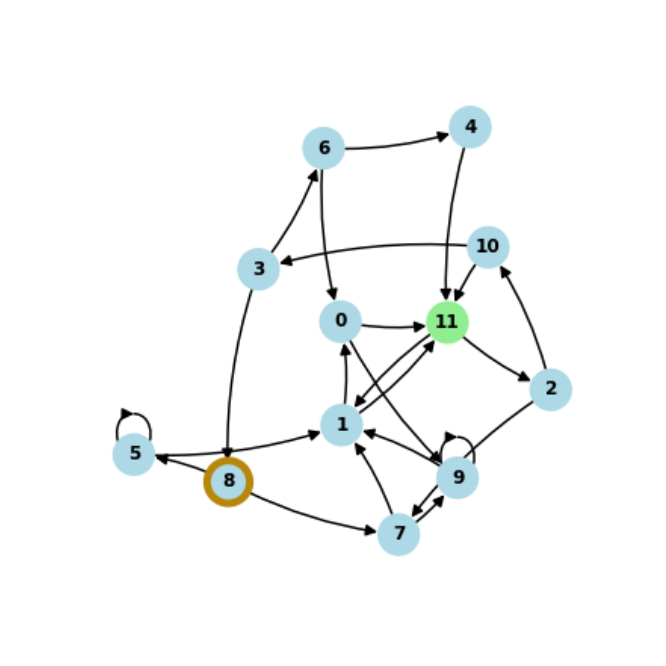

In [7]:
tokens, embeddings, cache = evaluate_ad_agent(model, env_config, 10, return_cache=True)
plt.figure(figsize = (12, 12))
plt.imshow(env_config.env.render(), interpolation='bilinear')
plt.axis('off')
plt.show()

In [8]:
env_config.env.reward_rules

[[11, -1, 1, 1.0, 1.0, -1]]

In [17]:
print(tokens.shape)
labels = []
prev_obs = -1
for t in range(tokens.shape[1]):
    obs = tokens[0, t, :12].argmax().item()
    act = tokens[0, t, 12:14].argmax().item()
    reward = int(tokens[0, t, -1].item())
    labels.append(f"{prev_obs},{act}->{obs}r{reward}")
    prev_obs = obs
    


torch.Size([1, 240, 15])


In [18]:
pattern = get_previous_token_head_detection_pattern(embeddings[0, :, 0]).cuda()
detect_head(model.transformer, embeddings, pattern)

tensor([[0.0261, 0.0384, 0.0168, 0.0257],
        [0.0130, 0.0404, 0.9245, 0.0354],
        [0.0233, 0.9569, 0.0138, 0.0104],
        [0.0751, 0.0290, 0.0084, 0.0149],
        [0.0115, 0.0365, 0.0174, 0.0181],
        [0.0216, 0.0202, 0.0124, 0.0149]])

In [19]:
_, cache = model.transformer.run_with_cache(embeddings)
print(_.shape)

torch.Size([1, 240, 256])


In [12]:
def display_head(cache, labels, layer, head, n_episodes=3):
    average_patterns = cache[f"blocks.{layer}.attn.hook_pattern"]
    matrix = average_patterns[0, head, :24*n_episodes, :24*n_episodes].cpu()
    fig = px.imshow(
        matrix,
        labels=dict(x="AttendedPos", y="CurrentPos", color="Value"),
    )
    layout = dict(
        width=800,
        height=800,
        xaxis=dict(
            tickmode="array",
            tickvals=np.arange(len(labels)),
            ticktext=labels,
        ),
        yaxis=dict(
            tickmode="array",
            tickvals=np.arange(len(labels)),
            ticktext=labels,
        )
    )
    fig.update_layout(layout)

    fig.show()

    

In [21]:
display_head(cache, labels, 0, 1, 3)

In [14]:
cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_re

In [15]:
for i in range(6):
    
    print(cache[f"blocks.{i}.attn.hook_z"].norm())

tensor(39.4690, device='cuda:0')
tensor(241.0544, device='cuda:0')
tensor(269.1913, device='cuda:0')
tensor(368.0812, device='cuda:0')
tensor(320.3652, device='cuda:0')
tensor(282.5533, device='cuda:0')


In [16]:
model.transformer_config

TransformerModelConfig(d_model=256, n_heads=4, d_mlp=2048, d_head=64, n_layers=6, n_ctx=240, layer_norm=True, attn_only=False, state_embedding_type='linear', time_embedding_type='embedding', seed=1, device=device(type='cuda'))